In [1]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import pysentani as sti
survey = pd.read_excel('../data-anonymous/sentani-merged-cleaned-anonymous-2014-11-29.xlsx')
survey['access_type'] = sti.access_type(survey)

In [2]:
powers = {'TV':0.075, 'fridge':0.200, 'radio':0.100, 'fan':0.135, 'rice_cooker':0.700, 'lighting':0.400}
appliance_list = ['TV', 'fridge', 'radio', 'fan', 'rice_cooker', 'lighting']

for appliance in appliance_list:
    # create column label from appliance names
    wk_col = 'app_{}_per_wk'.format(appliance)
    hr_col = 'app_{}_hrs'.format(appliance)
    energy_col = 'daily_{}_energy'.format(appliance)
    weekly_hr_col = 'weekly_{}_hrs'.format(appliance)
    survey[weekly_hr_col] = survey[wk_col] * survey[hr_col]  
    #excluding impossible values
    survey[weekly_hr_col] = survey[weekly_hr_col][survey[weekly_hr_col]<=168]
    survey[energy_col] = survey[weekly_hr_col] / 7 * powers[appliance]

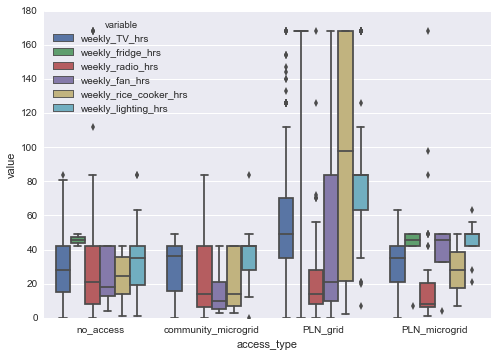

In [3]:
wk_columns = [f for f in survey.columns if 'weekly' in f]
id_columns = ['village_name', 'demand_point', 'access_type']

columns = wk_columns + id_columns
plt_data = pd.melt(survey[columns], value_vars=wk_columns, id_vars=id_columns)

sns.boxplot(data=plt_data, hue='variable', y='value', x='access_type')

The boxplot shows a large variance in the distribution of rice cooker use hours per week. We will need to investigate this data field further to see what is going on.

In [4]:
survey['weekly_rice_cooker_hrs'].describe()

count    167.000000
mean      89.359281
std       69.632791
min        1.000000
25%       21.000000
50%       49.000000
75%      168.000000
max      168.000000
Name: weekly_rice_cooker_hrs, dtype: float64

Responses are present at 168 hours per week with 75% of responses greater than 20 hours per week.  We can see weekly values of 168 hours per week which is unlikely to reflect actual usage.  The first check will calculate the amount of households that report a maximum weekly hour response.

In [5]:
max_value_check = survey['weekly_rice_cooker_hrs'] == 168
max_value_check.astype('float').sum()

62.0

There are 62 reported max value responses out of 167 total.

Now only response values less than 168 will be calculated to see what effect it has.

In [6]:
no_max_values = survey['weekly_rice_cooker_hrs'][survey['weekly_rice_cooker_hrs']<168]
no_max_values.describe()

count    105.000000
mean      42.923810
std       43.306976
min        1.000000
25%       14.000000
50%       28.000000
75%       49.000000
max      154.000000
Name: weekly_rice_cooker_hrs, dtype: float64

While the values decrease significantly, most of the response values are still very high.

we will now analyze a different set of data regrading appliance use in Lake Sentani provided by Advancing Energy(#confirm?) for comparison. Information provided about kWh per use is used to provide an estimate of use hours per week. Average power for a rice cooker will currently be estimated at 700 W. Table represents sample mean per household.

| Appliance            | kWh per use   | Use         | Use per Week |
| -------------------- | ------------- | ----------- | ------------ |
| TV + Parabola        | 0.040         | hour        | 40 hours     |
| Washing Machine      | 0.03          | kg          | 7 kg         |
| Water Pump           | 0.027         | 100 liters  | 500 liters   |
| Water Boiler         | 0.090         | liter       | 35 liters    |
| Rice Cooker          | 0.380         | kg          | 3.5 kg       |
| Fridge, big          | 2.600         | day         | 24/7         |
| Fridge, small, high  | 2.000         | day         | 24/7         |
| Fridge, small, low   | 1.900         | day         | 24/7         |

$$rice\ cooker\left(\frac{hours}{week}\right) = 0.38\frac{kWh}{kg} \left(\frac{3.5kg}{wk}\right)   \left(\frac{rice\ cooker}{.700kW}\right)$$

In [7]:
ae_rc_weekly_hrs = 0.38 * 3.5 / .700
ae_rc_weekly_hrs

1.9000000000000001

This calculation reflects that a rice cooker is used an average of 1.9 hours per week per household which seems reasonably likely. Most of the original survey data falls well above this value.